In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

## Utils

In [2]:
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
import math
import torch
from torch.optim.optimizer import Optimizer, required

# Early Stopping
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, model_dir, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.model_dir = model_dir

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score - self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'best_model.pt')
        self.val_loss_min = val_loss

## Activation

In [3]:
import numpy as np
from torch.nn import functional


def shifted_softplus(x):
    r"""Compute shifted soft-plus activation function.
    .. math::
       y = \ln\left(1 + e^{-x}\right) - \ln(2)
    Args:
        x (torch.Tensor): input tensor.
    Returns:
        torch.Tensor: shifted soft-plus of input.
    """
    return functional.softplus(x) - np.log(2.0)

## Base

In [4]:
from scipy.spatial import distance_matrix
import torch
from torch import nn
from torch.nn import init
from torch.nn.init import xavier_uniform_
from functools import partial
import math

from torch.nn.init import constant_

zeros_initializer = partial(constant_, val=0.0)


class Dense(nn.Linear):
    r"""Fully connected linear layer with activation function.
    .. math::
       y = activation(xW^T + b)
    Args:
        in_features (int): number of input feature :math:`x`.
        out_features (int): number of output features :math:`y`.
        bias (bool, optional): if False, the layer will not adapt bias :math:`b`.
        activation (callable, optional): if None, no activation function is used.
        weight_init (callable, optional): weight initializer from current weight.
        bias_init (callable, optional): bias initializer from current bias.
    """

    def __init__(
        self, in_features,
        out_features,
        bias=True,
        activation=None,
        weight_init=xavier_uniform_,
        bias_init=zeros_initializer,
    ):
        self.weight_init = weight_init
        # self.bias_init = bias_init
        self.activation = activation
        # initialize linear layer y = xW^T + b
        super(Dense, self).__init__(in_features, out_features, bias)


    def reset_parameters(self):
        """Reinitialize model weight and bias values."""
        self.weight_init(self.weight)
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)



    def forward(self, inputs):
        """Compute layer output.
        Args:
            inputs (dict of torch.Tensor): batch of input values with shape B * N * F
            mask (callable, optional): mask for remove non-exist atoms in molecular with shape B * N
        Returns:
            torch.Tensor: layer output.
        """
        # compute linear layer y = xW^T + b
        y = super(Dense, self).forward(inputs)
        # add activation function
        if self.activation:
            y = self.activation(y)
        return y


## Cutoff

In [5]:
"""
    Cut off Layer: Make mask for cut off distance that higher than r cutoff
    Param:
        dist: distance matrix of atoms in molecular: Shape is B*N*N
        
    Out: 
        mask: mask of cutoff distance
"""

import torch 
from torch import nn
import torch.nn.functional as F 
from torch.nn import Parameter

import numpy as np 

from scipy.spatial import distance_matrix

class Cutoff(nn.Module):
    def __init__(self, cutoff=5.0):
        super(Cutoff, self).__init__()
        self.cutoff = cutoff
    
    def forward(self, dist):
        """Compute cutoff.
        Args:
            distances (torch.Tensor): values of interatomic distances.
        Returns:
            torch.Tensor: values of cutoff function.
        """
        mask = (dist <= self.cutoff).float()
        return mask 


## Data

In [6]:
import pandas as pd 
import numpy as np 
import pickle
from scipy.spatial import distance_matrix
from sklearn.model_selection import train_test_split

import torch
from torch import nn 
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader
import time
atoms_z_value = {'H': 1, 'C': 12, 'O': 16, 'N': 14, 'F': 19}

def type2value(atom_type):
    return [atoms_z_value[i] for i in atom_type]

class MoleculeData(Dataset):
    def __init__(self, data_path, structure_path, molecules_ids, mol_path, train=True, name_feat='homo', for_Jcoupling=False):
        self.data = pd.read_csv(data_path)
        self.structure = pd.read_csv(structure_path)
        self.molecules_ids = molecules_ids
        self.for_Jcoupling = for_Jcoupling
        self.mol_feats = pd.read_csv(mol_path)
        self.name_feat = name_feat
        self.group_struct = np.array(self.structure.groupby('molecule_name'))
        self.train = train
        start = time.time()
        for i in range(len(self.group_struct)):
            self.group_struct[i][1] = self.group_struct[i][1].values
            if i % 5000 == 0:
                print(i)
        self.dict_struct_mol = {name: struct for name, struct in self.group_struct}
        self.group_mol_feats = np.array(self.mol_feats.groupby('molecule_name'))
        for i in range(len(self.group_mol_feats )):
            self.group_mol_feats[i][1] = self.group_mol_feats[i][1].values
            if i % 5000 == 0:
                print(i)
        self.dict_mol_feats = {name: feats for name, feats in self.group_mol_feats}
        self.name_mol_feats = np.array(self.mol_feats.columns)
        self.name_feats_to_index = {name: idx for idx, name in enumerate(self.name_mol_feats)}
        print(' -- ex time is %s second' % (time.time() - start))



    def __len__(self):
        return len(self.molecules_ids)

    def __getitem__(self, idx):
        # struct = self.structure[self.structure['molecule_name'] == self.molecules_ids[idx]]
        struct = self.dict_struct_mol[self.molecules_ids[idx]]
        num_atoms = len(struct)
        atoms_input = np.zeros((29))
        distances = np.zeros((29, 29))
        y_true = np.zeros((29, 29, 1))
        mask_non_exist_node = np.zeros((29, 29))
        xyz = struct[:, 3:]
        atom_type = struct[:, 2]
        atom_feat = type2value(atom_type)
        atom_feat = np.array(atom_feat)
        # data = self.data[self.data['molecule_name'] == self.molecules_ids[idx]]
        # atom_index_0 = data['atom_index_0'].values.reshape(-1)
        # atom_index_1 = data['atom_index_1'].values.reshape(-1)
        distance = distance_matrix(xyz, xyz)
        mask = (distance + np.eye(len(distance))) != 0
        mask = mask.astype(np.float)
        node_mask = np.zeros((29))
        node_mask[np.arange(num_atoms)] = 1
        # print(mask.shape)
        mask_non_exist_node[:mask.shape[0], :mask.shape[1]] = mask
        atoms_input[:atom_feat.shape[0]] = atom_feat
        distances[:distance.shape[0], :distance.shape[1]] = distance
        if self.train == False:
            y_true = None
        else:
            if self.for_Jcoupling:
                y_true = None
                # y = np.zeros_like(distance)
                # y[atom_index_0, atom_index_1] = data['scalar_coupling_constant'].values.reshape(-1)
                # y[atom_index_1, atom_index_0] = y[atom_index_0, atom_index_1]
                # y_true[:y.shape[0], :y.shape[1], 0] = y
                # y_true = y_true.reshape(-1, 1)
            else:
                # y_true = self.mol_feats[self.mol_feats['molecule_name'] == self.molecules_ids[idx]]['homo'].values
                y_true = self.dict_mol_feats[self.molecules_ids[idx]].reshape(-1)
                # print(y_true)
                idx_feat = self.name_feats_to_index[self.name_feat]
                # print(idx_feat)
                y_true = y_true[idx_feat]
        
        return atoms_input, distances, y_true, mask_non_exist_node, node_mask

class MoleculeData_v1(Dataset):
    def __init__(self, molecules_ids, mol_path, adj_path, dict_mol_feats, dict_struct_mol, train=True, name_feat='alpha', for_Jcoupling=False):
        self.molecules_ids = molecules_ids
        self.for_Jcoupling = for_Jcoupling
        self.mol_feats = pd.read_csv(mol_path)
        self.name_feat = name_feat
        self.train = train
        self.dict_struct_mol = dict_struct_mol
        self.dict_mol_feats = dict_mol_feats
        self.name_mol_feats = np.array(self.mol_feats.columns)
        self.name_feats_to_index = {name: idx for idx, name in enumerate(self.name_mol_feats)}
        with open(adj_path, 'rb') as f:
            self.adj_matrix = pickle.load(f)
        print('DONE')
    
        

    def __len__(self):
        return len(self.molecules_ids)

    def __getitem__(self, idx):
        struct = self.dict_struct_mol[self.molecules_ids[idx]]
        num_atoms = len(struct)
        atoms_input = np.zeros((29))
        distances = np.zeros((29, 29))
        y_true = np.zeros((29, 29, 1))
        # mask_non_exist_node = np.zeros((29, 29))
        adj = self.adj_matrix[self.molecules_ids[idx]]
        xyz = struct[:, 3:]
        atom_type = struct[:, 2]
        atom_feat = type2value(atom_type)
        atom_feat = np.array(atom_feat)
        distance = distance_matrix(xyz, xyz)
        # mask = (distance + np.eye(len(distance))) != 0
        # mask = mask.astype(np.float)
        node_mask = np.zeros((29))
        node_mask[np.arange(num_atoms)] = 1
        # print(mask.shape)
        # mask_non_exist_node[:mask.shape[0], :mask.shape[1]] = mask
        atoms_input[:atom_feat.shape[0]] = atom_feat
        distances[:distance.shape[0], :distance.shape[1]] = distance
        if self.train == False:
            y_true = None
        else:
            if self.for_Jcoupling:
                y_true = None
              
            else:
                y_true = self.dict_mol_feats[self.molecules_ids[idx]].reshape(-1)
                idx_feat = self.name_feats_to_index[self.name_feat]
                y_true = y_true[idx_feat]
        
        return atoms_input, distances, y_true, adj, node_mask



def get_train_valid_test_mol_name():
    train_df = pd.read_csv('../input/qm9-csv/atoms_df.csv')
    num_atoms = train_df.groupby('molecule_name').agg({"atom_type": 'count'}).values.reshape(-1)
    mols_name = train_df['molecule_name'].unique()
    mols_name_train, mols_name_valid = train_test_split(mols_name, test_size=0.15, random_state=42, stratify=num_atoms)
    valid_df = train_df.loc[train_df['molecule_name'].isin(mols_name_valid)]
    num_atoms_valid = valid_df.groupby('molecule_name').agg({'atom_type': 'count'}).values.reshape(-1)
    print(num_atoms_valid)
    mols_name_valid, mols_name_test = train_test_split(valid_df['molecule_name'].unique(), test_size=0.5, random_state=42)
    return mols_name_train, mols_name_valid, mols_name_test


def gen_distence():
    structure_df = pd.read_csv('../input/champs-scalar-coupling/structures.csv')
    n_mols_train = len(structure_df['molecule_name'].unique())
    distances = np.zeros((n_mols_train, 29, 29, 1))
    for i, struct in enumerate(structure_df.groupby('molecule_name')):
        distance = np.zeros((29, 29, 1))
        # print(type(struct))
        # print(struct[1])
        xyz = struct[1][['x', 'y', 'z']].values
        dist = distance_matrix(xyz, xyz)
        distance[:dist.shape[0], :dist.shape[1], 0] = dist
        distances[i] = distance
    print(distances[0])
    np.savez_compressed("distances.npz" , distances)

def gen_type_atom():
    structure_df = pd.read_csv('../input/champs-scalar-coupling/structures.csv')
    n_mols_train = len(structure_df['molecule_name'].unique())
    type_atom_list = np.zeros((n_mols_train, 29, 1))
    for i, struct in enumerate(structure_df.groupby('molecule_name')):
        atom = np.zeros((29, 1))
        atom_type = struct[1]['atom'].values
        atom_feat = type2value(atom_type)
        atom_feat = np.array(atom_feat)
        atom[:atom_feat.shape[0], 0] = atom_feat
        type_atom_list[i] = atom
    
    print(type_atom_list[0])
    np.savez_compressed('atom_feat.npz', type_atom_list)

def get_mol_features(data_path):
    """
    Get molecular features for testing and training model
    """
    data = pd.read_csv(data_path)
    print(data.head())
    print(data.columns)



## Embedding layer

In [7]:
"""
    Embedding Layer: Create embedding for atoms and edges in molecular.
"""

import torch
from torch import nn
from torch.nn import Parameter
import torch.nn.functional as F 

class EmbeddingLayer(nn.Module):
    def __init__(self, max_z, out_dims):
        super(EmbeddingLayer, self).__init__()
        self.out_dims = out_dims
        max_z = 116
        self.embedd = nn.Embedding(max_z, out_dims, padding_idx=0)
        # self.embedd = nn.Linear(1, out_dims, bias=False)

    def forward(self, Z_value):
        """
            Create embedding for Z value of atom
        """
        return self.embedd(Z_value)

## Radam

In [8]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

class PlainRAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                beta2_t = beta2 ** state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:                    
                    step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    step_size = group['lr'] / (1 - beta1 ** state['step'])
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss


class AdamW(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, warmup = 0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, warmup = warmup)
        super(AdamW, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamW, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                
                if group['warmup'] > state['step']:
                    scheduled_lr = 1e-8 + state['step'] * group['lr'] / group['warmup']
                else:
                    scheduled_lr = group['lr']

                step_size = scheduled_lr * math.sqrt(bias_correction2) / bias_correction1
                
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * scheduled_lr, p_data_fp32)

                p_data_fp32.addcdiv_(-step_size, exp_avg, denom)

                p.data.copy_(p_data_fp32)

        return loss

## RBF 

In [9]:
import torch
from torch import nn
import numpy as np 

from scipy.spatial import distance_matrix


def gaussian_smearing(distances, offset, widths, centered=False):
    r"""Smear interatomic distance values using Gaussian functions.
    Args:
        distances (torch.Tensor): interatomic distances of (N_b x N_at x N_nbh) shape.
        offset (torch.Tensor): offsets values of Gaussian functions.
        widths: width values of Gaussian functions.
        centered (bool, optional): If True, Gaussians are centered at the origin and
            the offsets are used to as their widths (used e.g. for angular functions).
    Returns:
        torch.Tensor: smeared distances (B x N x N x N_g).
    """
    if not centered:
        # compute width of Gaussian functions (using an overlap of 1 STDDEV)
        coeff = -0.5 / torch.pow(widths, 2)
        # Use advanced indexing to compute the individual components
        diff = distances[ :, :, :, None] - offset[None, None, None, :]
    else:
        # if Gaussian functions are centered, use offsets to compute widths
        coeff = -0.5 / torch.pow(offset, 2)
        # if Gaussian functions are centered, no offset is subtracted
        diff = distances[ :, :, None]
    # compute smear distance values
    gauss = torch.exp(coeff * torch.pow(diff, 2))
    return gauss


class GaussianSmearing(nn.Module):
    r"""Smear layer using a set of Gaussian functions.
    Args:
        start (float, optional): center of first Gaussian function, :math:`\mu_0`.
        stop (float, optional): center of last Gaussian function, :math:`\mu_{N_g}`
        n_gaussians (int, optional): total number of Gaussian functions, :math:`N_g`.
        centered (bool, optional): If True, Gaussians are centered at the origin and
            the offsets are used to as their widths (used e.g. for angular functions).
        trainable (bool, optional): If True, widths and offset of Gaussian functions
            are adjusted during training process.
    """

    def __init__(
        self, start=0.0, stop=5.0, n_gaussians=25, centered=False, trainable=False
    ):
        super(GaussianSmearing, self).__init__()
        # compute offset and width of Gaussian functions
        offset = torch.linspace(start, stop, n_gaussians)
        # width is gamma parameter
        widths = torch.FloatTensor((offset[1] - offset[0]) * torch.ones_like(offset))
        if trainable:
            self.width = nn.Parameter(widths)
            self.offsets = nn.Parameter(offset)
        else:
            self.register_buffer("width", widths)
            self.register_buffer("offsets", offset)
        self.centered = centered

    def forward(self, distances):
        """Compute smeared-gaussian distance values.
        Args:
            distances (torch.Tensor): interatomic distance values of
                (B x N x N) shape.
        Returns:
            torch.Tensor: layer output of (B x N x N x N_g) shape.
        """
        return gaussian_smearing(
            distances, self.offsets, self.width, centered=self.centered
        )


## Interaction

In [10]:
import torch
from torch import nn
from torch.nn import Parameter
import torch.nn.functional as F 


class GenerateFilter(nn.Module):
    def __init__(self, n_basis, n_filter):
        super(GenerateFilter, self).__init__()
        self.n_basis = n_basis
        self.n_filter = n_filter
        self.FC1 = Dense(self.n_basis, self.n_filter, activation=shifted_softplus)
        self.FC2 = Dense(self.n_filter, self.n_filter)

    def forward(self, rbf_filer, cutoff_mask):
        """
            Generate continuous filter
            Params:
                rbf_filter: rbf_filter that was generated in RBF layer.
                    Shape B * N * N * n_basis
                cutoff_mask: cutoff mask for remove distance higher than r cut-off
                    Shape N * N
            Out:
                filter: Shape B * N * N * n_filter
        """
        gen_filter = self.FC1(rbf_filer)
        gen_filter = self.FC2(gen_filter)
        gen_filter = gen_filter * cutoff_mask.unsqueeze(-1)
      
        return gen_filter

class CFConv(nn.Module):
    def __init__(self, n_filter, in_atom_feat, out_atom_feat):
        super(CFConv, self).__init__()
        self.n_filter = n_filter
        self.in_atom_feat = in_atom_feat
        self.out_atom_feat = out_atom_feat
        self.in2f = Dense(self.in_atom_feat, self.n_filter, activation=None)
        self.f2out = Dense(self.n_filter, self.out_atom_feat, activation=shifted_softplus)

        

    def forward(self, x, rbf_filter, mask):
        """
            CFConv for update atom features
            Params:
                x: atom features with shape B * N*in_atom_feat
                rbf_filter: filter with shape B * N*N*n_filter
                mask: remove non exist node, shape B * N * N
            Out:
                new_x: update atom features with shape N*out_atom_feat
            Update in future: 
                If want to aggregate message from neighborhood node, using mask neighborhood as param and 
                element wise multiplication it with filter.
        """
        n_atoms = x.shape[1]
        batch_size = x.shape[0]
        x_ = self.in2f(x)
        # reshape x_ to n_atom*n_atom_n_filter for element wise multiplication
        x_ = x_.repeat(1, n_atoms, 1).reshape(batch_size,n_atoms, n_atoms, -1)

        # filter
        x_ = x_ * rbf_filter
        # remove non exist node
        x_ = x_ * mask.unsqueeze(-1)

        # aggregator message, just sum message from all node in the molecular, future we can aggregator message from neighborhood by using adjacency matrix mask
        x_ = x_.sum(2)
        x_new = self.f2out(x_)
        # x_new = self.f2out_2(x_new)
        return x_new


class InteractionLayer(nn.Module):
    def __init__(self, n_filter, in_atom_feat, out_atom_feat, n_gaussians=200, cutoff=5.0):
        super(InteractionLayer, self).__init__()
        self.n_filter = n_filter
        self.in_atom_feat = in_atom_feat
        self.out_atom_feat = out_atom_feat
        self.gen_filter = GenerateFilter(n_gaussians, self.n_filter)
        self.cfconv = CFConv( self.n_filter, self.in_atom_feat, self.out_atom_feat)
        self.out_layer = Dense(out_atom_feat, out_atom_feat, activation=None, bias=True)
        self.RBF_expansion = GaussianSmearing(start=0.0, stop=20.0, n_gaussians=n_gaussians)
        self.Cutoff = Cutoff(cutoff)

    def forward(self, x, distance_matrix, mask):
        """
            Interaction Layer: compute interaction of atom wise in molecular.
            Params:
                x: atom features with shape B*N*in_atom_feat
                distance matrix: distance matrix of atoms in molecular. 
                    Shape is B * N * N
                mask: remove non exist node
                    Shape is B * N * N
            Out: 
                x_new: new atom features with shape B * N * out_atom_feat
            Here we have n_basis is equal n_gaussians and both are the number of filter the generate in RBF expanssion
        """
        # print('distance matrix is ', distance_matrix, '\n with shape is ', distance_matrix.shape )
        rbf_filter = self.RBF_expansion(distance_matrix)
        # print('rbf filter is ', rbf_filter, '\n with shape is ', rbf_filter.shape)
        cutoff_mask = self.Cutoff(distance_matrix)
        # print('cut of mask is ', cutoff_mask, '\n with shape is ', cutoff_mask.shape)
        filter_ = self.gen_filter(rbf_filter, cutoff_mask)
        # print('filter is ', filter_, '\n with shape is ', filter_.shape)
        x_new = self.cfconv(x, filter_, mask)
        # print('x new after through cfconv is ', x_new, '\nwith shape is ', x_new.shape)
        x_new = self.out_layer(x_new)
        # print("out ", x_new)

        return x_new


## Readout

In [11]:
import torch
from torch import nn 
from torch.nn import Parameter
import torch.nn.functional as F 

class Readout_basis(nn.Module):
    def __init__(self, in_atom_feat, state_dims):
        super(Readout_basis, self).__init__()
        self.FC1 = Dense(in_atom_feat, in_atom_feat, shifted_softplus)
        self.FC2 = Dense(in_atom_feat, state_dims, shifted_softplus)
        self.FC3 = Dense(state_dims, state_dims, shifted_softplus)
        self.FC4 = Dense(2*state_dims, state_dims)
        self.out_layer = Dense(state_dims, 1, shifted_softplus)

    def forward(self, x):
        """
            Calculate J coupling of atom pair in the molecular
            Params:
                x: atom features with shape N * in_atom_feat
            Out:
                J coupling with shape N^2 * 1
        """
        N = x.shape[1]
        B = x.shape[0]
        x_new = self.FC1(x)
        x_new = self.FC2(x_new)
        x_new = self.FC3(x_new)
        pair = torch.cat([x_new.repeat(1, 1, N).view(B, N*N, -1), x_new.repeat(1, N, 1)], dim=-1)
        pair = self.FC4(pair)
        out = self.out_layer(pair)
        return out
    


## Schnet

In [12]:
import torch
from torch import nn
from torch.nn import Parameter
import torch.nn.functional as F 


class Schnet_basic(nn.Module):
    def __init__(self, n_atom_basis, n_interactions=3, cutoff=5.0, n_gaussians=200, max_z=100, n_filter=128):
        super(Schnet_basic, self).__init__()
        self.embedd_layer = EmbeddingLayer(max_z, n_atom_basis)
        self.interactions = nn.ModuleList([InteractionLayer(n_filter, n_atom_basis, n_atom_basis, n_gaussians) for _ in range(n_interactions)])
        # self.readout = Readout_basis(n_atom_basis,n_atom_basis)
        self.atom_wise_64 = Dense(n_atom_basis, 64, activation=shifted_softplus)
        self.atom_wise_32_1 = Dense(64, 32, activation=shifted_softplus)

        self.atom_wise_1 = Dense(32, 1, activation=None)

    def forward(self, z, distance_matrix, mask, node_mask):
        """
            Params: 
                z: nuclear charge of atoms
                distance_matrix: distances matrix between atoms in molecular
            Out:
                J coupling between atom pairs
        """                
        x = self.embedd_layer(z)
        # print(x.shape)
        # print(distance_matrix.shape)
        # mask = distance_matrix != 0
        # mask = mask.float() + torch.eye(29).unsqueeze(0).cuda()
        # print('begin, node feats x is ', x, ' \nshape of x is ', x.shape)
        for interacton in self.interactions:
            v = interacton(x, distance_matrix, mask)
            x = x + v
            # print('node feats after interaction layer is ', x, '\n shape of x is ', x.shape)

        # out = self.readout(x)
        x = self.atom_wise_64(x)
        x = self.atom_wise_32_1(x)
        x = self.atom_wise_1(x)
        x = x * node_mask.unsqueeze(-1)
        x = x.squeeze()
        out = x.sum(-1)

        return out



In [13]:
# !mkdir '..working/model/version_1'

## Train

In [14]:
from __future__ import division
from __future__ import print_function

import os
import glob
import time
import random
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
import tqdm
from tqdm import tqdm_notebook as tqdm

import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')
import random 
import pandas as pd
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.is_available())

model_dir = './model/version_1/'

def log_mae(out, label):
    out = out.view(-1)
    label = label.view(-1)
    loss = torch.abs(out - label)
    loss = loss.mean()
    loss = torch.log(loss)
    return loss

def mae(out, label):
    out = out.view(-1)
    label = label.view(-1)
    loss = torch.abs(out - label)
    loss = loss.mean()
    return loss

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

train_data_path = '../input/champs-scalar-coupling/train.csv'
structure_path = '../input/champs-scalar-coupling/structures.csv'
mol_path = '../input/qm9-csv/stats_df_paper_used.csv'
adj_path = '../input/qm9-extradata/adj_matrix_with_align.pkl'
# train_atom_feats_path = 'trainatom_feat.npz'
# train_distances_path = 'traindistances.npz'
# train_mask_none_exist_path = 'trainmask_none_exist.npz'
# train_node_mask_path = 'trainnode_mask.npz'

# test_atom_feats_path = 'testatom_feat.npz'
# test_distances_path = 'testdistances.npz'
# test_mask_none_exist_path = 'testmask_none_exist.npz'
# test_node_mask_path = 'testnode_mask.npz'


structure = pd.read_csv(structure_path)
mol_feats = pd.read_csv(mol_path)


# name_feat = 'U0'
# scale_max = mol_feats[name_feat].max()
# scale_min = mol_feats[name_feat].min()
# scale_norm = scale_max - scale_min
# scale_mid = (scale_max + scale_min) / 2
# mol_feats[name_feat + "no_norm"] = mol_feats[name_feat]
# mol_feats[name_feat] = (mol_feats[name_feat] - scale_mid) / scale_norm

# print(scale_mid, scale_norm)
# print(mol_feats.head())

group_struct = np.array(structure.groupby('molecule_name'))
start = time.time()
for i in range(len(group_struct)):
    group_struct[i][1] = group_struct[i][1].values
    if i % 5000 == 0:
        print(i)
dict_struct_mol = {name: struct for name, struct in group_struct}
group_mol_feats = np.array(mol_feats.groupby('molecule_name'))
for i in range(len(group_mol_feats )):
    group_mol_feats[i][1] = group_mol_feats[i][1].values
    if i % 5000 == 0:
        print(i)
dict_mol_feats = {name: feats for name, feats in group_mol_feats}
print(' -- ex time is %s second' % (time.time() - start))







cuda
True
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
 -- ex time is 186.8605535030365 second


In [15]:
mols_name_train, mols_name_valid, mols_name_test  = get_train_valid_test_mol_name()
print(len(mols_name_train), len(mols_name_valid), len(mols_name_test))
# dataset_train = MoleculeData(train_data_path, structure_path, mols_name_train, mol_path)
# dataset_valid = MoleculeData(train_data_path, structure_path, mols_name_valid, mol_path)
dataset_train = MoleculeData_v1(mols_name_train, mol_path, adj_path, dict_mol_feats, dict_struct_mol)
dataset_valid = MoleculeData_v1(mols_name_valid, mol_path, adj_path, dict_mol_feats, dict_struct_mol)
dataset_test = MoleculeData_v1(mols_name_test, mol_path, adj_path, dict_mol_feats, dict_struct_mol)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (2,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


[ 3  8  7 ... 19 17 19]
111158 9808 9809
DONE
DONE
DONE


In [16]:
dataloader_train = DataLoader(dataset_train, batch_size=32, num_workers=10, shuffle=False)
dataloader_valid = DataLoader(dataset_valid, batch_size=32, shuffle=False, num_workers=10)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False, num_workers=10)

In [17]:
from torch.optim.lr_scheduler import *
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

def train(n_epoch, patience=5):
    # Model 
    model = Schnet_basic(n_atom_basis=128, n_interactions=6, cutoff=20.0, n_gaussians=200, max_z=100, n_filter=128)
    model = model.to(device)

    print(model)
    for name, param in model.named_parameters():
        if param.requires_grad:
            print (name, param.data)
    print(f'The model has {count_parameters(model):,} trainable parameters')

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = mae

    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []
    train_lost_iter = []
    valid_lost_iter = []
    lr_iter = []
    lr_epoch = []
    predict = []

    early_stopping = EarlyStopping(model_dir=model_dir, patience=patience, verbose=True)
#     scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1)
#     scheduler = ReduceLROnPlateau(optimizer, 'min', 0.1, 8)
#     scheduler = StepLR(optimizer, step_size=25, gamma=0.8)
    iters = len(dataloader_train)

    for epoch in range(1, n_epoch + 1):
        model.train()
        for step, (atom_feat, distance, y, mask, node_mask) in enumerate(dataloader_train):
#             scheduler.step(epoch + i / iters)
#             lr_iter.append(scheduler.get_lr())
            optimizer.zero_grad()

            atom_feat = atom_feat.to(device, dtype=torch.long)
            distance = distance.to(device, dtype=torch.float)
            y = y.to(device, dtype=torch.float)
            mask = mask.to(device, dtype=torch.float)
            node_mask = node_mask.to(device, dtype=torch.float)

            atom_feat = Variable(atom_feat)
            distance = Variable(distance)
            y = Variable(y)
            mask = Variable(mask)
            node_mask = Variable(node_mask)

            y_predict = model(atom_feat, distance, mask, node_mask)
            loss = criterion(y_predict, y)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            train_lost_iter.append(loss.item())
#             print(y, y_predict)
            if step % 200 == 0:
                print('y predict shape: ', y_predict.shape)
                print('step: ', step)
                print('loss train: ', np.array(train_losses).mean())
                print("y: ", y[0].reshape(-1))
                print("y predict: ", y_predict[0].reshape(-1))

        model.eval()
        for step, (atom_feat, distance, y, mask, node_mask) in enumerate(dataloader_valid):
            atom_feat = atom_feat.to(device, dtype=torch.long)
            distance = distance.to(device, dtype=torch.float)
            y = y.to(device, dtype=torch.float)
            mask = mask.to(device, dtype=torch.float)
            node_mask = node_mask.to(device, dtype=torch.float)

            atom_feat = Variable(atom_feat)
            distance = Variable(distance)
            y = Variable(y)
            mask = Variable(mask)
            node_mask = Variable(node_mask)

            y_predict = model(atom_feat, distance, mask, node_mask)
            loss = criterion(y_predict, y)
            valid_losses.append(loss.item())
            valid_lost_iter.append(loss.item())
#             predict.append(y_predict)
        
#         scheduler.step()
        
        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

#         lr_epoch.append(scheduler.get_lr())

        epoch_len = len(str(n_epoch))        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epoch:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        print(print_msg)
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
#         torch.save(model.state_dict(), model_dir+'mode_' + str(epoch) + '_.pth')
#         torch.save(optimizer.state_dict(), model_dir+'opti_' + str(epoch) + '_.pth')
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)        
        if early_stopping.early_stop:
            print("Early stopping")
            # torch.save(optimizer.state_dict(), 'optimizer_of_bestmodel.pt')
            print(epoch)
            break
    
    return avg_train_losses, avg_valid_losses, train_lost_iter, valid_lost_iter, lr_iter, lr_epoch



In [18]:
%%time
avg_train_losses, avg_valid_losses, train_lost_iter, valid_lost_iter, lr_iter, lr_epoch = train(n_epoch=30, patience=8)

Schnet_basic(
  (embedd_layer): EmbeddingLayer(
    (embedd): Embedding(116, 128, padding_idx=0)
  )
  (interactions): ModuleList(
    (0): InteractionLayer(
      (gen_filter): GenerateFilter(
        (FC1): Dense(in_features=200, out_features=128, bias=True)
        (FC2): Dense(in_features=128, out_features=128, bias=True)
      )
      (cfconv): CFConv(
        (in2f): Dense(in_features=128, out_features=128, bias=True)
        (f2out): Dense(in_features=128, out_features=128, bias=True)
      )
      (out_layer): Dense(in_features=128, out_features=128, bias=True)
      (RBF_expansion): GaussianSmearing()
      (Cutoff): Cutoff()
    )
    (1): InteractionLayer(
      (gen_filter): GenerateFilter(
        (FC1): Dense(in_features=200, out_features=128, bias=True)
        (FC2): Dense(in_features=128, out_features=128, bias=True)
      )
      (cfconv): CFConv(
        (in2f): Dense(in_features=128, out_features=128, bias=True)
        (f2out): Dense(in_features=128, out_features=1

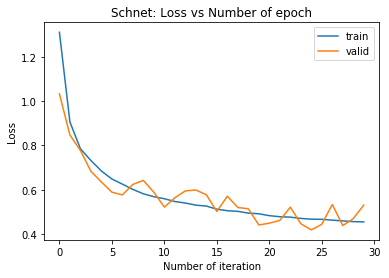

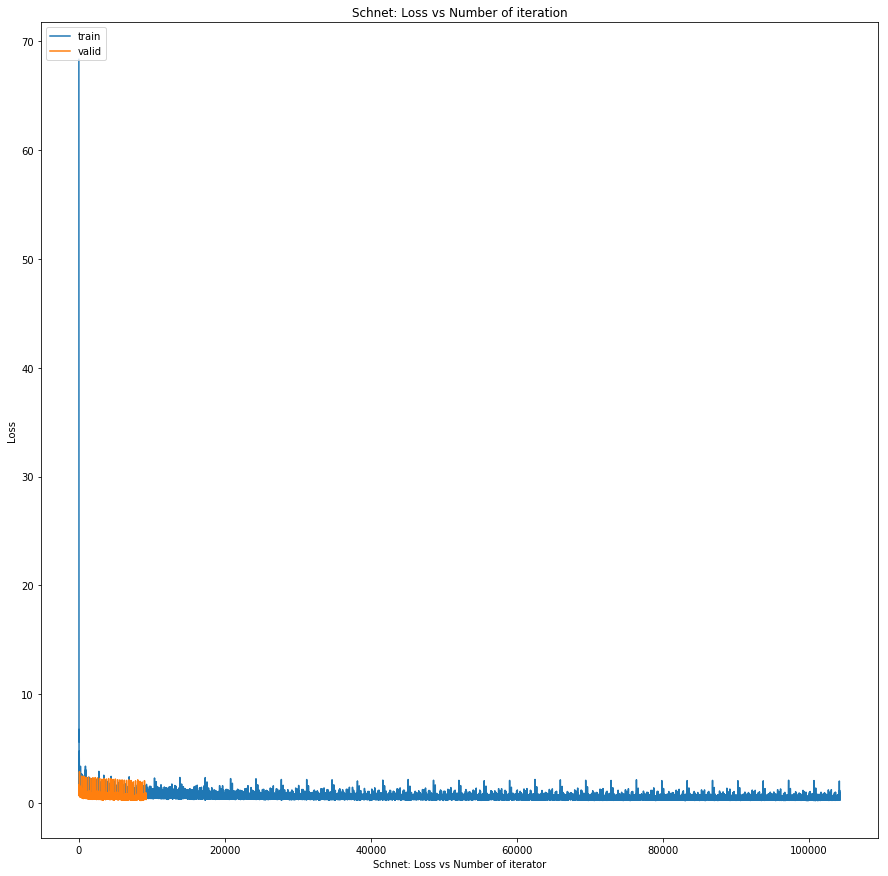

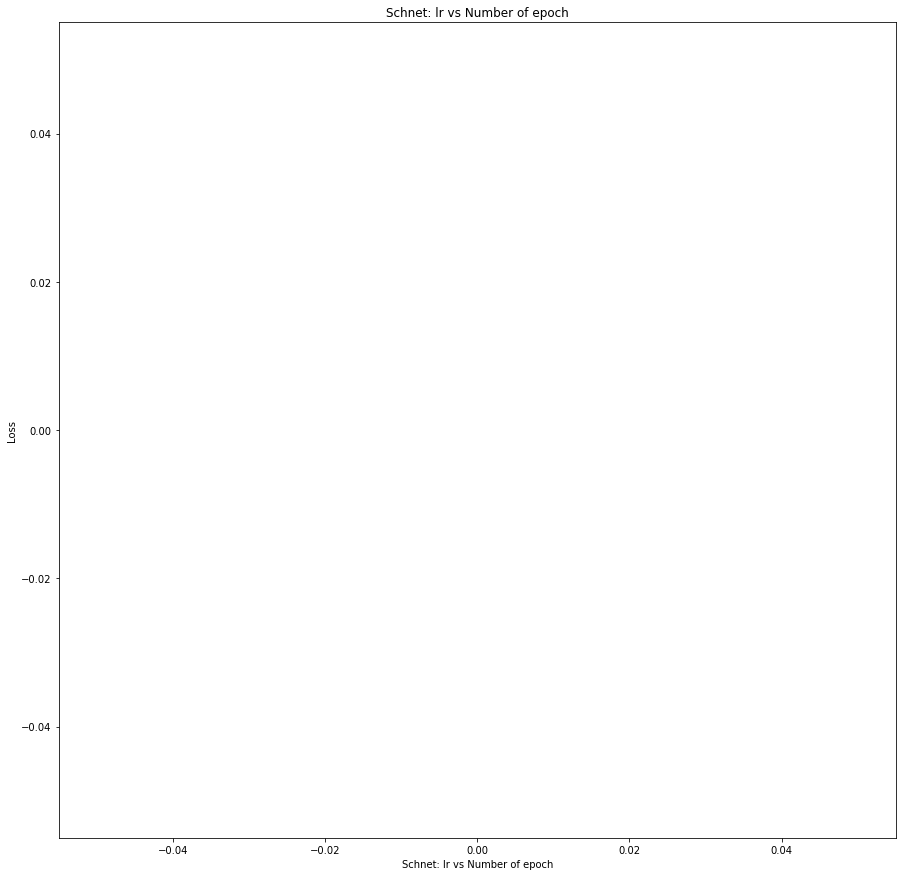

In [19]:
plt.plot(avg_train_losses)
plt.plot(avg_valid_losses)

plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.legend(['train', 'valid'], loc='upper right')
plt.title("Schnet: Loss vs Number of epoch")
plt.show()


plt.figure(figsize=(15,15))
plt.plot(train_lost_iter)
plt.plot(valid_lost_iter)
plt.xlabel("Schnet: Loss vs Number of iterator")
plt.ylabel("Loss")
plt.legend(['train', 'valid'], loc='upper left')
plt.title("Schnet: Loss vs Number of iteration")
plt.show()

plt.figure(figsize=(15,15))
plt.plot(lr_epoch)
plt.xlabel("Schnet: lr vs Number of epoch")
plt.ylabel("Loss")
plt.title("Schnet: lr vs Number of epoch")
plt.show()
